In [1]:
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
sys.path.insert(0, caffe_root + 'examples/tripletloss')
import caffe

In [2]:
%%writefile tripletloss/tripletloss_layer.py
import caffe
import numpy as np

class TripletLossLayer(caffe.Layer):
    """
    Compute the Triplet Loss based on the Google's FaceNet paper.
    """

    def setup(self, bottom, top):
        # check if input pair is a triplet
        if len(bottom) != 3:
            raise Exception("Need three inputs to compute triplet loss. The bottom length was {}".format(len(bottom)))
            
        params = eval(self.param_str)
        try:
            self.margin = float(params['margin'])
        except:
            self.margin = 1.0
            
        try:
            self.debug = params['debug']
        except:
            self.debug = 0

    def reshape(self, bottom, top):
        # check input shapes match
        if bottom[0].count != bottom[1].count or bottom[1].count != bottom[2].count:
            raise Exception("Inputs must have the same dimension.")
        # differences are shape of inputs
        self.diff_pos = np.zeros_like(bottom[0].data, dtype=np.float32)
        self.diff_neg = np.zeros_like(bottom[0].data, dtype=np.float32)
        # normalized
        self.norm_anc = bottom[0].data
        self.log('norm_anc = {}'.format(self.norm_anc))
        self.norm_pos = bottom[1].data
        self.log('norm_pos = {}'.format(self.norm_pos))
        self.norm_neg = bottom[2].data
        self.log('norm_neg = {}'.format(self.norm_neg))
        # loss
        self.batch_size = bottom[0].data.shape[0]
        self.log('batch_size = {}'.format(self.batch_size))
        self.loss = np.zeros(self.batch_size, dtype=np.float32)
        # loss output is scalar
        top[0].reshape(1)

    def forward(self, bottom, top):
        """ computes a loss
        Loss = SUM[i->N](Di_pos - Di_neg + margin), 0 <= i <= N(the batch size)
        Dpos = sqrt(L2(IMGi_anc - IMGi_pos))
        Dneg = sqrt(L2(IMGi_anc - IMGi_neg))
        """
        
        self.diff_pos[...] = self.norm_anc - self.norm_pos
        self.log('diff_pos = {}'.format(self.diff_pos))
        self.diff_neg[...] = self.norm_anc - self.norm_neg
        self.log('diff_neg = {}'.format(self.diff_neg))
        dist_pos = np.sum(self.diff_pos**2, axis=1)
        self.log('dist_pos = {}'.format(dist_pos))
        dist_neg = np.sum(self.diff_neg**2, axis=1)
        self.log('dist_neg = {}'.format(dist_neg))
        # calculate a loss for each item
        for i in range(self.batch_size):
            loss = dist_pos[i] - dist_neg[i] + self.margin
            self.log('loss[{}] = {}'.format(i, loss))
            self.loss[i] = max(0, loss)
        total_loss = np.sum(self.loss)
        self.log('total loss = {}, mini_batch_size={}'.format(total_loss, self.batch_size))
        top[0].data[...] = total_loss / self.batch_size

    def backward(self, top, propagate_down, bottom):
        """ computes a gradient w.r.t. each IMG
        dL/dDanc = SUM[i->N]{2(IMGi_neg - IMGi_pos)} if Lossi > 0 else 0
        dL/dDpos = SUM[i->N](-2(IMGi_anc - IMGi_pos)) if Lossi > 0 else 0
        dL/dDneg = SUM[i->N](2(IMGi_anc - IMGi_neg)) if Lossi > 0 else 0
        """
        # gradient w.r.t. Danc
        diff_org = self.norm_neg - self.norm_pos
        for i in range(self.batch_size):
            if self.loss[i] == 0:
                diff_org[i] = 0
        bottom[0].diff[...] = 2 * diff_org
        self.log('anc diff = {}'.format(bottom[0].diff))
        
        # gradient w.r.t. Dpos
        for i in range(self.batch_size):
            self.diff_pos[i] = 0
        bottom[1].diff[...] = -2 * self.diff_pos
        self.log('pos diff = {}'.format(bottom[1].diff))
        
        # gradient w.r.t. Dneg
        for i in range(self.batch_size):
            self.diff_neg[i] = 0
        bottom[2].diff[...] = 2 * self.diff_neg
        self.log('neg diff = {}'.format(bottom[2].diff))
        
    def log(self, message):
        if self.debug == 0:
            return
        
        print(message)
        
class PairwiseDistanceLayer(caffe.Layer):
    
    def setup(self, bottom, top):
        # check input pair
        if len(bottom) != 2:
            raise Exception("Need two inputs to compute a pair wise distance. The bottom length was {}".format(len(bottom)))
            
        params = eval(self.param_str)
        try:
            self.debug = params['debug']
        except:
            self.debug = 0
        
    def reshape(self, bottom, top):
        # check input shapes match
        if bottom[0].count != bottom[1].count:
            raise Exception("Inputs must have the same dimension.")
            
        self.batch_size = bottom[0].data.shape[0]
        top[0].reshape(1)
            
    def forward(self, bottom, top):
        """ computes a distance
        Dpos = sqrt(L2(IMGi_acr - IMGi_pos))
        """
        dist = np.sum((bottom[0].data - bottom[1].data)**2, axis=1)
        self.log('L2 squared dist = {}'.format(dist))
        top[0].data[...] = np.sum(dist) / self.batch_size
        
    def log(self, message):
        if self.debug == 0:
            return
        
        print(message)
        

Overwriting tripletloss/tripletloss_layer.py


# Hello Test Forward

In [3]:
import tempfile
import numpy as np
from caffe import layers as L, params as P

def load_net(net_proto):
    f = tempfile.NamedTemporaryFile(mode='w+', delete=False)
    f.write(str(net_proto))
    f.close()
    return caffe.Net(f.name, caffe.TEST)

def l2normed(embeddings, dim):
    """Returns L2-normalized instances of vec; i.e., for each instance x in embeddings,
    computes  x / ((x ** 2).sum() ** 0.5). Assumes embeddings has shape N x dim."""
    denom = L.Reduction(embeddings, axis=1, operation=P.Reduction.SUMSQ)
    denom = L.Power(denom, power=(-0.5))
    denom = L.Reshape(denom, num_axes=0, axis=-1, shape=dict(dim=[1]))
    denom = L.Tile(denom, axis=1, tiles=dim)
    return L.Eltwise(embeddings, denom, operation=P.Eltwise.PROD)

def example_network(batch_size):
    n = caffe.NetSpec()

    # we use the dummy data layer to control the 
    # shape of the inputs to the layer we are testing
    ip_dims = [3*batch_size, 3]
    label_dims = [batch_size]
    n.ip, n.label = L.DummyData(shape=[dict(dim=ip_dims),dict(dim=label_dims)],
                                        transform_param=dict(scale=1.0/255.0),
                                        ntop=2)
    
    n.slice_anc, n.slice_pos, n.slice_neg = L.Slice(n.ip, slice_param=dict(axis=0), ntop=3)
    n.slice_anc_norm = l2normed(n.slice_anc, 3)
    n.slice_pos_norm = l2normed(n.slice_pos, 3)
    n.slice_neg_norm = l2normed(n.slice_neg, 3)
    n.triplet = L.Python(n.slice_anc_norm, n.slice_pos_norm, n.slice_neg_norm, loss_weight=1, python_param=dict(module='tripletloss_layer', layer='TripletLossLayer', param_str='{\"margin\": 1.0, \"debug\": 1}'))
    return n.to_proto()


In [4]:
IMG_ANC = [1.0, 1.0, 1.0]
# ||f(IMG_ANC)||_2 = sqrt(1**2 + 1**2 + 1**2) = 1.73...
IMG_POS = [1.0, 1.0, 1.0]
# ||f(IMG_POS)||_2 = sqrt(1**2 + 1**2 + 1**2) = 1.73...
IMG_NEG = [0., 0., 0.]
# ||f(IMG_NEG)||_2 = sqrt(0**2 + 0**2 + 0**2) = 0

# embeddings is an 1D-array of features
# here, the size of features is 3, 3*32bit = 96bit
# (batch_size, feature_size)
embeddings = np.array([IMG_ANC, IMG_POS, IMG_NEG], dtype=np.float32)
print('embeddings shape = {}'.format(embeddings.shape))

net_proto = example_network(1)
with open('tripletloss/mnist_tripletloss_train_test_10_auto.prototxt', 'w') as f:
    f.write(str(net_proto))
net = load_net(net_proto)
net.blobs['ip'].data[...] = embeddings

net.forward()

for name in net.blobs:
    print('{}'.format(name))
    print('value = {}'.format(net.blobs[name].data))
    
print('running backward...')
net.backward()

print('diff anc = {}'.format(net.blobs['slice_anc'].diff))
print('diff pos = {}'.format(net.blobs['slice_pos'].diff))
print('diff neg = {}'.format(net.blobs['slice_neg'].diff))

embeddings shape = (3, 3)
norm_anc = [[ 0.  0.  0.]]
norm_pos = [[ 0.  0.  0.]]
norm_neg = [[ 0.  0.  0.]]
batch_size = 1
norm_anc = [[ 0.57735026  0.57735026  0.57735026]]
norm_pos = [[ 0.57735026  0.57735026  0.57735026]]
norm_neg = [[ nan  nan  nan]]
batch_size = 1
diff_pos = [[ 0.  0.  0.]]
diff_neg = [[ nan  nan  nan]]
dist_pos = [ 0.]
dist_neg = [ nan]
loss[0] = nan
total loss = 0.0, mini_batch_size=1
ip
value = [[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 0.  0.  0.]]
label
value = [ 0.]
slice_anc
value = [[ 1.  1.  1.]]
slice_pos
value = [[ 1.  1.  1.]]
slice_neg
value = [[ 0.  0.  0.]]
slice_anc_slice_anc_0_split_0
value = [[ 1.  1.  1.]]
slice_anc_slice_anc_0_split_1
value = [[ 1.  1.  1.]]
slice_pos_slice_anc_1_split_0
value = [[ 1.  1.  1.]]
slice_pos_slice_anc_1_split_1
value = [[ 1.  1.  1.]]
slice_neg_slice_anc_2_split_0
value = [[ 0.  0.  0.]]
slice_neg_slice_anc_2_split_1
value = [[ 0.  0.  0.]]
Reduction1
value = [ 3.]
Power1
value = [ 0.57735026]
Reshape1
value = [[ 0.57735026]]

In [5]:
IMG_ANC = [10.0, 5.0, 100.0]
IMG_POS = [30.0, 10.0, 20.0]
IMG_NEG = [100., 2., 50.]
embeddings = np.array([IMG_ANC, IMG_POS, IMG_NEG], dtype=np.float32)
print('embeddings shape = {}'.format(embeddings.shape))

net_proto = example_network(1)
net = load_net(net_proto)
net.blobs['ip'].data[...] = embeddings

net.forward()

for name in net.blobs:
    print('{}'.format(name))
    print('value = {}'.format(net.blobs[name].data))
    
print('running backward...')
net.backward()

print('diff anc = {}'.format(net.blobs['slice_anc'].diff))
print('diff pos = {}'.format(net.blobs['slice_pos'].diff))
print('diff neg = {}'.format(net.blobs['slice_neg'].diff))

embeddings shape = (3, 3)
norm_anc = [[ 0.  0.  0.]]
norm_pos = [[ 0.  0.  0.]]
norm_neg = [[ 0.  0.  0.]]
batch_size = 1
norm_anc = [[ 0.0993808   0.0496904   0.99380797]]
norm_pos = [[ 0.80178374  0.26726124  0.53452247]]
norm_neg = [[ 0.89428413  0.01788568  0.44714206]]
batch_size = 1
diff_pos = [[-0.70240295 -0.21757084  0.4592855 ]]
diff_neg = [[-0.79490334  0.03180472  0.54666591]]
dist_pos = [ 0.75165015]
dist_neg = [ 0.93172652]
loss[0] = 0.819923639297
total loss = 0.819923639297, mini_batch_size=1
ip
value = [[  10.    5.  100.]
 [  30.   10.   20.]
 [ 100.    2.   50.]]
label
value = [ 0.]
slice_anc
value = [[  10.    5.  100.]]
slice_pos
value = [[ 30.  10.  20.]]
slice_neg
value = [[ 100.    2.   50.]]
slice_anc_slice_anc_0_split_0
value = [[  10.    5.  100.]]
slice_anc_slice_anc_0_split_1
value = [[  10.    5.  100.]]
slice_pos_slice_anc_1_split_0
value = [[ 30.  10.  20.]]
slice_pos_slice_anc_1_split_1
value = [[ 30.  10.  20.]]
slice_neg_slice_anc_2_split_0
value = [[

# Hello Training with MNIST

embeddings size = 10

In [6]:
%%writefile tripletloss/mnist_tripletloss_train_test_10.prototxt
name: "mnist_tripletloss_train_test_10"
layer {
  name: "triplet_data"
  type: "ImageData"
  top: "triplet_data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    scale: 0.00390625
  }
  image_data_param {
    source: "/home/researcher/caffe-tripletloss/examples/tripletloss/mnist/trainlist_64.txt"
    batch_size: 192
  }
}
layer {
  name: "triplet_data"
  type: "ImageData"
  top: "triplet_data"
  top: "label"
  include {
    phase: TEST
  }
  transform_param {
    scale: 0.00390625
  }
  image_data_param {
    source: "/home/researcher/caffe-tripletloss/examples/tripletloss/mnist/trainlist_64.txt"
    batch_size: 192
  }
}
layer {
  name: "slice_triplet"
  type: "Slice"
  bottom: "triplet_data"
  top: "anchor"
  top: "positive"
  top: "negative"
  slice_param {
    slice_dim: 0
  }
}

################# ANCHOR #############
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "anchor"
  top: "conv1"
  param {
    name: "conv1_w"
    lr_mult: 1
  }
  param {
    name: "conv1_b"
    lr_mult: 2
  }
  convolution_param {
    num_output: 20
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  param {
    name: "conv2_w"
    lr_mult: 1
  }
  param {
    name: "conv2_b"
    lr_mult: 2
  }
  convolution_param {
    num_output: 50
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "ip1"
  param {
    name: "ip1_w"
    lr_mult: 1
  }
  param {
    name: "ip1_b"
    lr_mult: 2
  }
  inner_product_param {
    num_output: 500
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "ip1"
  top: "ip1"
}
layer {
  name: "ip2"
  type: "InnerProduct"
  bottom: "ip1"
  top: "feat"
  param {
    name: "ip2_w"
    lr_mult: 1
  }
  param {
    name: "ip2_b"
    lr_mult: 2
  }
  inner_product_param {
    num_output: 10
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}

###################### POSITIVE ###################

layer {
  name: "conv1_p"
  type: "Convolution"
  bottom: "positive"
  top: "conv1_p"
  param {
    name: "conv1_w"
    lr_mult: 1
  }
  param {
    name: "conv1_b"
    lr_mult: 2
  }
  convolution_param {
    num_output: 20
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool1_p"
  type: "Pooling"
  bottom: "conv1_p"
  top: "pool1_p"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2_p"
  type: "Convolution"
  bottom: "pool1_p"
  top: "conv2_p"
  param {
    name: "conv2_w"
    lr_mult: 1
  }
  param {
    name: "conv2_b"
    lr_mult: 2
  }
  convolution_param {
    num_output: 50
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool2_p"
  type: "Pooling"
  bottom: "conv2_p"
  top: "pool2_p"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "ip1_p"
  type: "InnerProduct"
  bottom: "pool2_p"
  top: "ip1_p"
  param {
    name: "ip1_w"
    lr_mult: 1
  }
  param {
    name: "ip1_b"
    lr_mult: 2
  }
  inner_product_param {
    num_output: 500
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "relu1_p"
  type: "ReLU"
  bottom: "ip1_p"
  top: "ip1_p"
}
layer {
  name: "ip2_p"
  type: "InnerProduct"
  bottom: "ip1_p"
  top: "feat_p"
  param {
    name: "ip2_w"
    lr_mult: 1
  }
  param {
    name: "ip2_b"
    lr_mult: 2
  }
  inner_product_param {
    num_output: 10
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}

######################### NEGATIVE #########################

layer {
  name: "conv1_n"
  type: "Convolution"
  bottom: "negative"
  top: "conv1_n"
  param {
    name: "conv1_w"
    lr_mult: 1
  }
  param {
    name: "conv1_b"
    lr_mult: 2
  }
  convolution_param {
    num_output: 20
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool1_n"
  type: "Pooling"
  bottom: "conv1_n"
  top: "pool1_n"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2_n"
  type: "Convolution"
  bottom: "pool1_n"
  top: "conv2_n"
  param {
    name: "conv2_w"
    lr_mult: 1
  }
  param {
    name: "conv2_b"
    lr_mult: 2
  }
  convolution_param {
    num_output: 50
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool2_n"
  type: "Pooling"
  bottom: "conv2_n"
  top: "pool2_n"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "ip1_n"
  type: "InnerProduct"
  bottom: "pool2_n"
  top: "ip1_n"
  param {
    name: "ip1_w"
    lr_mult: 1
  }
  param {
    name: "ip1_b"
    lr_mult: 2
  }
  inner_product_param {
    num_output: 500
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "relu1_n"
  type: "ReLU"
  bottom: "ip1_n"
  top: "ip1_n"
}
layer {
  name: "ip2_n"
  type: "InnerProduct"
  bottom: "ip1_n"
  top: "feat_n"
  param {
    name: "ip2_w"
    lr_mult: 1
  }
  param {
    name: "ip2_b"
    lr_mult: 2
  }
  inner_product_param {
    num_output: 10
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}

############# L2 Normalization ############

layer {
  name: "Reduction1"
  type: "Reduction"
  bottom: "feat"
  top: "Reduction1"
  reduction_param {
    operation: SUMSQ
    axis: 1
  }
}
layer {
  name: "Power1"
  type: "Power"
  bottom: "Reduction1"
  top: "Power1"
  power_param {
    power: -0.5
  }
}
layer {
  name: "Reshape1"
  type: "Reshape"
  bottom: "Power1"
  top: "Reshape1"
  reshape_param {
    shape {
      dim: 1
    }
    axis: -1
    num_axes: 0
  }
}
layer {
  name: "Tile1"
  type: "Tile"
  bottom: "Reshape1"
  top: "Tile1"
  tile_param {
    axis: 1
    tiles: 10
  }
}
layer {
  name: "slice_anc_norm"
  type: "Eltwise"
  bottom: "feat"
  bottom: "Tile1"
  top: "slice_anc_norm"
  eltwise_param {
    operation: PROD
  }
}
layer {
  name: "Reduction2"
  type: "Reduction"
  bottom: "feat_p"
  top: "Reduction2"
  reduction_param {
    operation: SUMSQ
    axis: 1
  }
}
layer {
  name: "Power2"
  type: "Power"
  bottom: "Reduction2"
  top: "Power2"
  power_param {
    power: -0.5
  }
}
layer {
  name: "Reshape2"
  type: "Reshape"
  bottom: "Power2"
  top: "Reshape2"
  reshape_param {
    shape {
      dim: 1
    }
    axis: -1
    num_axes: 0
  }
}
layer {
  name: "Tile2"
  type: "Tile"
  bottom: "Reshape2"
  top: "Tile2"
  tile_param {
    axis: 1
    tiles: 10
  }
}
layer {
  name: "slice_pos_norm"
  type: "Eltwise"
  bottom: "feat_p"
  bottom: "Tile2"
  top: "slice_pos_norm"
  eltwise_param {
    operation: PROD
  }
}
layer {
  name: "Reduction3"
  type: "Reduction"
  bottom: "feat_n"
  top: "Reduction3"
  reduction_param {
    operation: SUMSQ
    axis: 1
  }
}
layer {
  name: "Power3"
  type: "Power"
  bottom: "Reduction3"
  top: "Power3"
  power_param {
    power: -0.5
  }
}
layer {
  name: "Reshape3"
  type: "Reshape"
  bottom: "Power3"
  top: "Reshape3"
  reshape_param {
    shape {
      dim: 1
    }
    axis: -1
    num_axes: 0
  }
}
layer {
  name: "Tile3"
  type: "Tile"
  bottom: "Reshape3"
  top: "Tile3"
  tile_param {
    axis: 1
    tiles: 10
  }
}
layer {
  name: "slice_neg_norm"
  type: "Eltwise"
  bottom: "feat_n"
  bottom: "Tile3"
  top: "slice_neg_norm"
  eltwise_param {
    operation: PROD
  }
}

############# Triplet Loss ###############
layer {
  name: "tripletloss"
  type: "Python"
  bottom: "slice_anc_norm"
  bottom: "slice_pos_norm"
  bottom: "slice_neg_norm"
  top: "loss"
  loss_weight: 1
  python_param {
    module: "tripletloss_layer"
    layer: "TripletLossLayer"
    param_str: '{\"margin\": 1.0}'
  }
  include {
    phase: TRAIN
  }
}
layer {
  name: "pos_dist"
  type: "Python"
  bottom: "slice_anc_norm"
  bottom: "slice_pos_norm"
  top: "pos_dist"
  python_param {
    module: "tripletloss_layer"
    layer: "PairwiseDistanceLayer"
    param_str: '{\"debug\": 0}'
  }
  include {
    phase: TEST
  }
}
layer {
  name: "neg_dist"
  type: "Python"
  bottom: "slice_anc_norm"
  bottom: "slice_neg_norm"
  top: "neg_dist"
  python_param {
    module: "tripletloss_layer"
    layer: "PairwiseDistanceLayer"
    param_str: '{\"debug\": 0}'
  }
  include {
    phase: TEST
  }
}
layer{
  name: "silence"
  type: "Silence"
  bottom: "label"
}

Overwriting tripletloss/mnist_tripletloss_train_test_10.prototxt


In [7]:
from mnist import MNIST
import os
mnist_data_dir = os.path.join(caffe_root, 'data/mnist')
mndata = MNIST(mnist_data_dir)
images, labels = mndata.load_training()
print('loaded {} images, {} labels'.format(len(images), len(labels)))
print('sample image at 0 = {}'.format(images[0]))

loaded 60000 images, 60000 labels
sample image at 0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 18, 18, 18, 126, 136, 175, 26, 166, 255, 247, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 36, 94, 154, 170, 253, 253, 253, 253, 253, 225, 172, 253, 242, 195, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 238, 253, 253, 253, 253, 253, 253, 253, 253, 251, 93, 82, 82, 56, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 219, 253, 253, 253, 253, 253, 198, 182, 247, 241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 156, 107, 253, 253, 205, 11, 0, 43, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [8]:
import cv2
from StringIO import StringIO

img_dir = '/home/researcher/caffe-tripletloss/examples/tripletloss/mnist/images'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# create a training list
triplet_dict = {'anchor': None, 'positive': None, 'negative': None}
anchor_list = StringIO()
pos_list = StringIO()
neg_list = StringIO()
batch_str = StringIO()
triplet_no = 0
batch_size = 0
for i, l in zip(images, labels):
    array = np.array(i)
    img = array.reshape((28, 28))
    
    if triplet_dict['anchor'] is None:
        # this becomes an anchor
        triplet_dict['anchor'] = [img, l]
    elif triplet_dict['positive'] is None:
        # check if this is the same label
        if triplet_dict['anchor'][1] == l:
            # this becomes a postive one
            triplet_dict['positive'] = [img, l]
    elif triplet_dict['anchor'][1] != l:
        # this becomes a negative one
        triplet_dict['negative'] = [img, l]
        
    if triplet_dict['negative'] is None:
        continue
    
    # write
    anchor_path = os.path.join(img_dir, '{}_anchor.jpg'.format(triplet_no))
    pos_path = os.path.join(img_dir, '{}_positive.jpg'.format(triplet_no))
    neg_path = os.path.join(img_dir, '{}_negative.jpg'.format(triplet_no))
    
    # image
    cv2.imwrite(anchor_path, triplet_dict['anchor'][0])
    cv2.imwrite(pos_path, triplet_dict['positive'][0])
    cv2.imwrite(neg_path, triplet_dict['negative'][0])
    
    # sample
    anchor_list.write('{} {}\n'.format(anchor_path, triplet_dict['anchor'][1]))
    pos_list.write('{} {}\n'.format(pos_path, triplet_dict['positive'][1]))
    neg_list.write('{} {}\n'.format(neg_path, triplet_dict['negative'][1]))
    
    # reset
    triplet_dict['anchor'] = None
    triplet_dict['positive'] = None
    triplet_dict['negative'] = None
    
    triplet_no += 1
    batch_size += 1
    
    if batch_size == 64:
        # write anchors first
        batch_str.write(anchor_list.getvalue())
        anchor_list.close()
        anchor_list = StringIO()
        # positive
        batch_str.write(pos_list.getvalue())
        pos_list.close()
        pos_list = StringIO()
        # negative
        batch_str.write(neg_list.getvalue())
        neg_list.close()
        neg_list = StringIO()
        # reset
        batch_size = 0
    
# finally, write sample list
with open(os.path.join(img_dir, '../' ,'trainlist_64.txt'), 'w') as f:
    f.write(batch_str.getvalue())
    batch_str.close()
    anchor_list.close()
    pos_list.close()
    neg_list.close()

In [9]:
%%writefile tripletloss/mnist_tripletloss_solver_10.prototxt
# The train/test net protocol buffer definition
train_net: "/home/researcher/caffe-tripletloss/examples/tripletloss/mnist_tripletloss_train_test_10.prototxt"
test_net: "/home/researcher/caffe-tripletloss/examples/tripletloss/mnist_tripletloss_train_test_10.prototxt"
# samples = 192 * 77 = 14784
test_iter: 77
# test at every epoch
test_interval: 77
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every epoch
display: 77
# The maximum number of iterations = 10 epochs
max_iter: 770
# snapshot intermediate results at every epoch
snapshot: 77
snapshot_prefix: "/home/researcher/caffe-tripletloss/examples/tripletloss/mnist/mnist_tripletloss"

Overwriting tripletloss/mnist_tripletloss_solver_10.prototxt


In [10]:
caffe.set_device(0)
caffe.set_mode_gpu()

# reset solver to avoid a continuous training over multiple runs
solver = None
solver = caffe.SGDSolver('/home/researcher/caffe-tripletloss/examples/tripletloss/mnist_tripletloss_solver_10.prototxt')

In [11]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('triplet_data', (192, 3, 28, 28)),
 ('label', (192,)),
 ('anchor', (64, 3, 28, 28)),
 ('positive', (64, 3, 28, 28)),
 ('negative', (64, 3, 28, 28)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('ip1', (64, 500)),
 ('feat', (64, 10)),
 ('feat_ip2_0_split_0', (64, 10)),
 ('feat_ip2_0_split_1', (64, 10)),
 ('conv1_p', (64, 20, 24, 24)),
 ('pool1_p', (64, 20, 12, 12)),
 ('conv2_p', (64, 50, 8, 8)),
 ('pool2_p', (64, 50, 4, 4)),
 ('ip1_p', (64, 500)),
 ('feat_p', (64, 10)),
 ('feat_p_ip2_p_0_split_0', (64, 10)),
 ('feat_p_ip2_p_0_split_1', (64, 10)),
 ('conv1_n', (64, 20, 24, 24)),
 ('pool1_n', (64, 20, 12, 12)),
 ('conv2_n', (64, 50, 8, 8)),
 ('pool2_n', (64, 50, 4, 4)),
 ('ip1_n', (64, 500)),
 ('feat_n', (64, 10)),
 ('feat_n_ip2_n_0_split_0', (64, 10)),
 ('feat_n_ip2_n_0_split_1', (64, 10)),
 ('Reduction1', (64,)),
 ('Power1', (64,)),
 ('Reshape1', (64, 1)),
 ('Tile1', (64, 10)),
 ('slice_anc_norm', (64, 10)),
 ('R

In [12]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 3, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('ip1', (500, 800)),
 ('ip2', (10, 500)),
 ('conv1_p', (20, 3, 5, 5)),
 ('conv2_p', (50, 20, 5, 5)),
 ('ip1_p', (500, 800)),
 ('ip2_p', (10, 500)),
 ('conv1_n', (20, 3, 5, 5)),
 ('conv2_n', (50, 20, 5, 5)),
 ('ip1_n', (500, 800)),
 ('ip2_n', (10, 500))]

In [13]:
%%time
itr_per_epoch = 77
niter = itr_per_epoch * 20

train_loss = np.zeros(niter)

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    loss = solver.net.blobs['loss'].data
    
    # output every epoch
    if it % itr_per_epoch == 0:
        print('loss at epoch {} = {}'.format(it/itr_per_epoch, loss))
    
    train_loss[it] = loss

loss at epoch 0 = [ 0.85033965]
loss at epoch 1 = [ 0.99302012]
loss at epoch 2 = [ 0.8766827]
loss at epoch 3 = [ 0.55279803]
loss at epoch 4 = [ 0.40801919]
loss at epoch 5 = [ 0.30903319]
loss at epoch 6 = [ 0.18014039]
loss at epoch 7 = [ 0.1296652]
loss at epoch 8 = [ 0.11750305]
loss at epoch 9 = [ 0.05959765]
loss at epoch 10 = [ 0.07006246]
loss at epoch 11 = [ 0.05378543]
loss at epoch 12 = [ 0.06332132]
loss at epoch 13 = [ 0.05327535]
loss at epoch 14 = [ 0.04025308]
loss at epoch 15 = [ 0.02750574]
loss at epoch 16 = [ 0.02782862]
loss at epoch 17 = [ 0.03689694]
loss at epoch 18 = [ 0.01833757]
loss at epoch 19 = [ 0.04366427]
CPU times: user 2min 33s, sys: 10.9 s, total: 2min 44s
Wall time: 2min 6s


# Deploy Test

In [14]:
%%writefile tripletloss/mnist_tripletloss_deploy_10.prototxt
name: "mnist_tripletloss_deploy_10"
layer {
  name: "data"
  type: "Input"
  top: "data"
  input_param { shape: { dim: 2 dim: 3 dim: 28 dim: 28 } }
}
layer {
  name: "slice_pair"
  type: "Slice"
  bottom: "data"
  top: "foo"
  top: "bar"
  slice_param {
    slice_dim: 0
  }
}

# foo => anchor
# bar => positive

################# ANCHOR #############
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "foo"
  top: "conv1"
  param {
    name: "conv1_w"
    lr_mult: 1
  }
  param {
    name: "conv1_b"
    lr_mult: 2
  }
  convolution_param {
    num_output: 20
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  param {
    name: "conv2_w"
    lr_mult: 1
  }
  param {
    name: "conv2_b"
    lr_mult: 2
  }
  convolution_param {
    num_output: 50
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "ip1"
  param {
    name: "ip1_w"
    lr_mult: 1
  }
  param {
    name: "ip1_b"
    lr_mult: 2
  }
  inner_product_param {
    num_output: 500
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "ip1"
  top: "ip1"
}
layer {
  name: "ip2"
  type: "InnerProduct"
  bottom: "ip1"
  top: "feat"
  param {
    name: "ip2_w"
    lr_mult: 1
  }
  param {
    name: "ip2_b"
    lr_mult: 2
  }
  inner_product_param {
    num_output: 10
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}

###################### POSITIVE ###################

layer {
  name: "conv1_p"
  type: "Convolution"
  bottom: "bar"
  top: "conv1_p"
  param {
    name: "conv1_w"
    lr_mult: 1
  }
  param {
    name: "conv1_b"
    lr_mult: 2
  }
  convolution_param {
    num_output: 20
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool1_p"
  type: "Pooling"
  bottom: "conv1_p"
  top: "pool1_p"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2_p"
  type: "Convolution"
  bottom: "pool1_p"
  top: "conv2_p"
  param {
    name: "conv2_w"
    lr_mult: 1
  }
  param {
    name: "conv2_b"
    lr_mult: 2
  }
  convolution_param {
    num_output: 50
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool2_p"
  type: "Pooling"
  bottom: "conv2_p"
  top: "pool2_p"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "ip1_p"
  type: "InnerProduct"
  bottom: "pool2_p"
  top: "ip1_p"
  param {
    name: "ip1_w"
    lr_mult: 1
  }
  param {
    name: "ip1_b"
    lr_mult: 2
  }
  inner_product_param {
    num_output: 500
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "relu1_p"
  type: "ReLU"
  bottom: "ip1_p"
  top: "ip1_p"
}
layer {
  name: "ip2_p"
  type: "InnerProduct"
  bottom: "ip1_p"
  top: "feat_p"
  param {
    name: "ip2_w"
    lr_mult: 1
  }
  param {
    name: "ip2_b"
    lr_mult: 2
  }
  inner_product_param {
    num_output: 10
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}

############# L2 Normalization ############

layer {
  name: "Reduction1"
  type: "Reduction"
  bottom: "feat"
  top: "Reduction1"
  reduction_param {
    operation: SUMSQ
    axis: 1
  }
}
layer {
  name: "Power1"
  type: "Power"
  bottom: "Reduction1"
  top: "Power1"
  power_param {
    power: -0.5
  }
}
layer {
  name: "Reshape1"
  type: "Reshape"
  bottom: "Power1"
  top: "Reshape1"
  reshape_param {
    shape {
      dim: 1
    }
    axis: -1
    num_axes: 0
  }
}
layer {
  name: "Tile1"
  type: "Tile"
  bottom: "Reshape1"
  top: "Tile1"
  tile_param {
    axis: 1
    tiles: 10
  }
}
layer {
  name: "slice_anc_norm"
  type: "Eltwise"
  bottom: "feat"
  bottom: "Tile1"
  top: "slice_anc_norm"
  eltwise_param {
    operation: PROD
  }
}
layer {
  name: "Reduction2"
  type: "Reduction"
  bottom: "feat_p"
  top: "Reduction2"
  reduction_param {
    operation: SUMSQ
    axis: 1
  }
}
layer {
  name: "Power2"
  type: "Power"
  bottom: "Reduction2"
  top: "Power2"
  power_param {
    power: -0.5
  }
}
layer {
  name: "Reshape2"
  type: "Reshape"
  bottom: "Power2"
  top: "Reshape2"
  reshape_param {
    shape {
      dim: 1
    }
    axis: -1
    num_axes: 0
  }
}
layer {
  name: "Tile2"
  type: "Tile"
  bottom: "Reshape2"
  top: "Tile2"
  tile_param {
    axis: 1
    tiles: 10
  }
}
layer {
  name: "slice_pos_norm"
  type: "Eltwise"
  bottom: "feat_p"
  bottom: "Tile2"
  top: "slice_pos_norm"
  eltwise_param {
    operation: PROD
  }
}

############# Triplet Loss ###############
layer {
  name: "pos_dist"
  type: "Python"
  bottom: "slice_anc_norm"
  bottom: "slice_pos_norm"
  top: "pos_dist"
  python_param {
    module: "tripletloss_layer"
    layer: "PairwiseDistanceLayer"
    param_str: '{\"debug\": 0}'
  }
  include {
    phase: TEST
  }
}

Overwriting tripletloss/mnist_tripletloss_deploy_10.prototxt


In [15]:
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [16]:
model_def = caffe_root + 'examples/tripletloss/mnist_tripletloss_deploy_10.prototxt'
model_weights = caffe_root + 'examples/tripletloss/mnist/mnist_tripletloss_iter_1463.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

img_anc shape = (28, 28, 3)


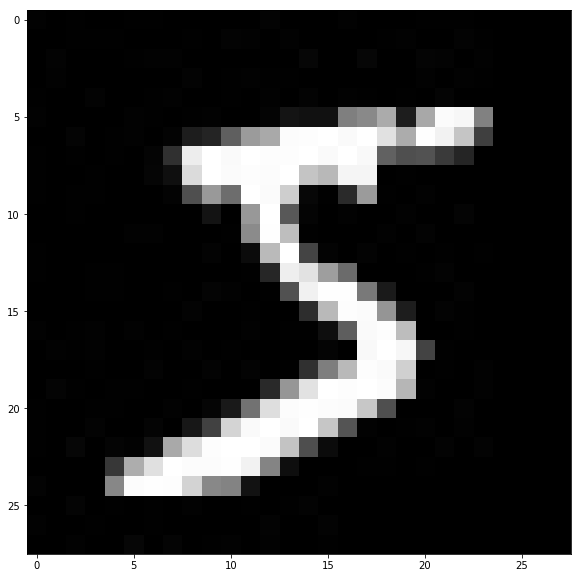

In [17]:
import cv2

img_anc = cv2.imread('/home/researcher/caffe-tripletloss/examples/tripletloss/mnist/images/0_anchor.jpg')
print('img_anc shape = {}'.format(img_anc.shape))
plt.imshow(img_anc)

img_pos shape = (28, 28, 3)


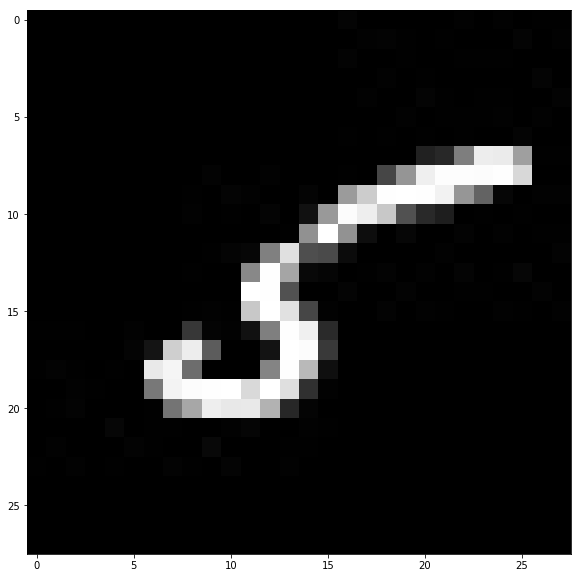

In [18]:
img_pos = cv2.imread('/home/researcher/caffe-tripletloss/examples/tripletloss/mnist/images/0_positive.jpg')
print('img_pos shape = {}'.format(img_pos.shape))
plt.imshow(img_pos)

img_neg shape = (28, 28, 3)


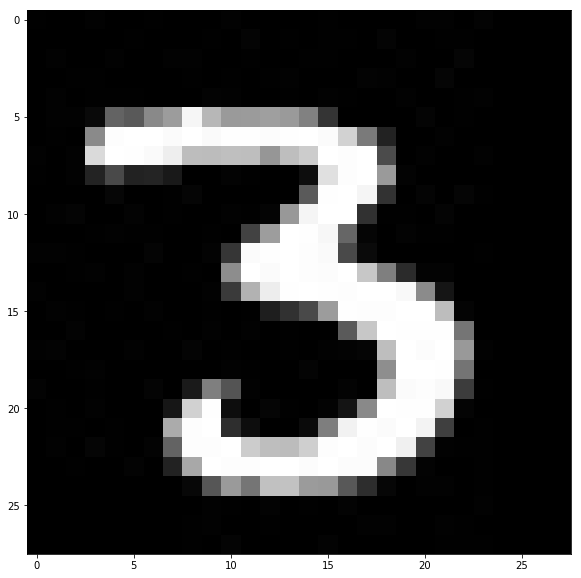

In [19]:
img_neg = cv2.imread('/home/researcher/caffe-tripletloss/examples/tripletloss/mnist/images/0_negative.jpg')
print('img_neg shape = {}'.format(img_neg.shape))
plt.imshow(img_neg)

In [20]:
img_anc_transposed = img_anc.transpose(2, 0, 1)
print('img_anc_transposed shape = {}'.format(img_anc_transposed.shape))
img_pos_transposed = img_pos.transpose(2, 0, 1)
print('img_pos_transposed shape = {}'.format(img_pos_transposed.shape))
img_neg_transposed = img_neg.transpose(2, 0, 1)
print('img_neg_transposed shape = {}'.format(img_neg_transposed.shape))

img_anc_transposed shape = (3, 28, 28)
img_pos_transposed shape = (3, 28, 28)
img_neg_transposed shape = (3, 28, 28)


In [21]:
# set a pair data
net.blobs['data'].data[...] = np.array([img_anc_transposed, img_pos_transposed])

# calculate distance
net.forward()

dist = net.blobs['pos_dist'].data
print('dist between anc and pos = {}'.format(dist))

dist between anc and pos = [ 0.32835513]


In [22]:
# set a pair data
net.blobs['data'].data[...] = np.array([img_anc_transposed, img_neg_transposed])

# calculate distance
net.forward()

dist = net.blobs['pos_dist'].data
print('dist between anc and neg = {}'.format(dist))

dist between anc and neg = [ 1.63734376]
